# Changing to Logspace
Switching to logspace for the mass and luminosity distances for the fitting. Hopefully this should produce a better fit since now the KDE estimates cannot go into negative galues in logspace and the uncertainty scales better with the means

In [1]:
import numpy as np
from scipy.stats import gaussian_kde
import pymc as pm
from pylab import *
import arviz as az
from astropy.cosmology import Planck18
from tqdm import tqdm
import seaborn as sns
from MCMC_functions import *
from astropy.cosmology import units as cu

sns.set_context('notebook')
sns.set_palette('colorblind')

import matplotlib
matplotlib.rcParams['font.family'] = 'serif' # so these plots can go into thesis


%matplotlib inline

21.842005079805304 2.341064941957475 72.90319790481104
(10000,)


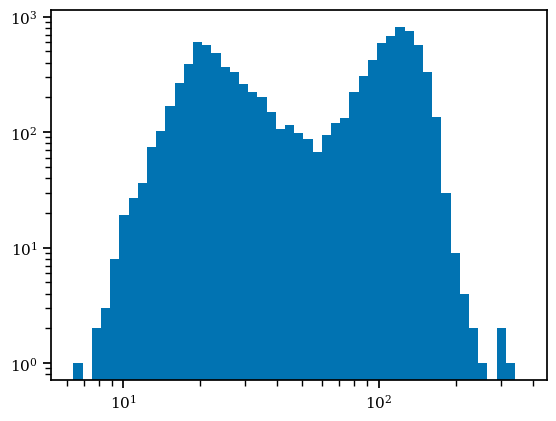

In [2]:
ms = generate_masses(f=0.5)
dLs = generate_dLs()
zs = dLs_to_zs(dLs)

m_det = ms*(1+zs)
print(np.mean(ms), np.mean(zs), np.mean(m_det))
print(m_det.shape)
plt.hist(m_det, bins=np.logspace(np.log10(min(m_det)), np.log10(max(m_det)), 50))
plt.xscale('log')
plt.yscale('log')

In [3]:
m_dls = m_det/dLs
sigma_dls = sigma_dL(m_dls)
sigma_ms  = sigma_m(m_dls)

100%|██████████| 8/8 [00:13<00:00,  1.63s/it]


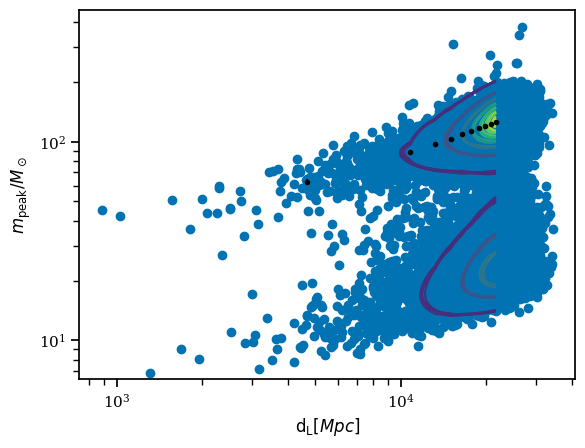

In [4]:
log_mass = np.log(m_det)
log_dl   = np.log(dLs)

n_events = len(m_det)
n_dLs=10
n_mc = 8
m_min = min(m_det)
m_max = max(m_det)
dL_min = min(dLs)
dL_max = max(dLs)
cutoff_d = 22000 #Mpc

m_grid = np.exp(np.linspace(np.log(m_min), np.log(m_max), 1024))
# m_grid = np.linspace(np.log(m_min), np.log(m_max), 1024)
d_low_dl = dLs[dLs < cutoff_d]
dL_cent = np.quantile(d_low_dl, np.linspace(0.01, 0.95, n_dLs))

DLG, MG = np.meshgrid(dL_cent, m_grid, indexing='ij')

mpeak_samples = np.zeros((n_mc, n_dLs))

for run in tqdm(range(n_mc)):

    m_det_mc = np.random.normal(log_mass, sigma_ms)
    d_Ls_mc = np.random.normal(log_dl, sigma_dls)


    
    arr = np.array([d_Ls_mc, m_det_mc])
    kde = gaussian_kde(arr)
    
    pdf = np.exp(kde(np.array([np.log(DLG).ravel(), np.log(MG).ravel()])).reshape(DLG.shape))

    for i in range(n_dLs):
        redshifted_min = 25*(1+cosmo.z_at_value(Planck18.luminosity_distance, dL_cent[i]*u.Mpc))
        mpeak_samples[run,i] = find_argmax_gridsearch(m_grid, pdf[i,:], mmin=redshifted_min)
    
    # kplot = sns.kdeplot(x=(d_Ls_mc), y=(m_det_mc), log_scale=True)
    plt.contour(DLG, MG, pdf) #had to do it a different way no because of the non-linear scaling
    
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.scatter(np.exp(d_Ls_mc), np.exp(m_det_mc))
plt.xlabel(r'$\mathrm{d_L}[Mpc]$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')
# plt.ylim(top=250)
plt.xscale('log')
plt.yscale('log')

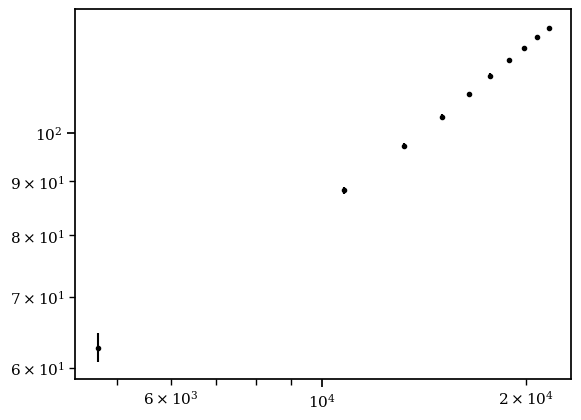

In [5]:
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')

plt.xscale('log')
plt.yscale('log')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
/Users/tanner/miniconda3/lib/python3.9/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 63 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 153 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6083, but should be close to 0.8. Try to increase the number of tuning steps.


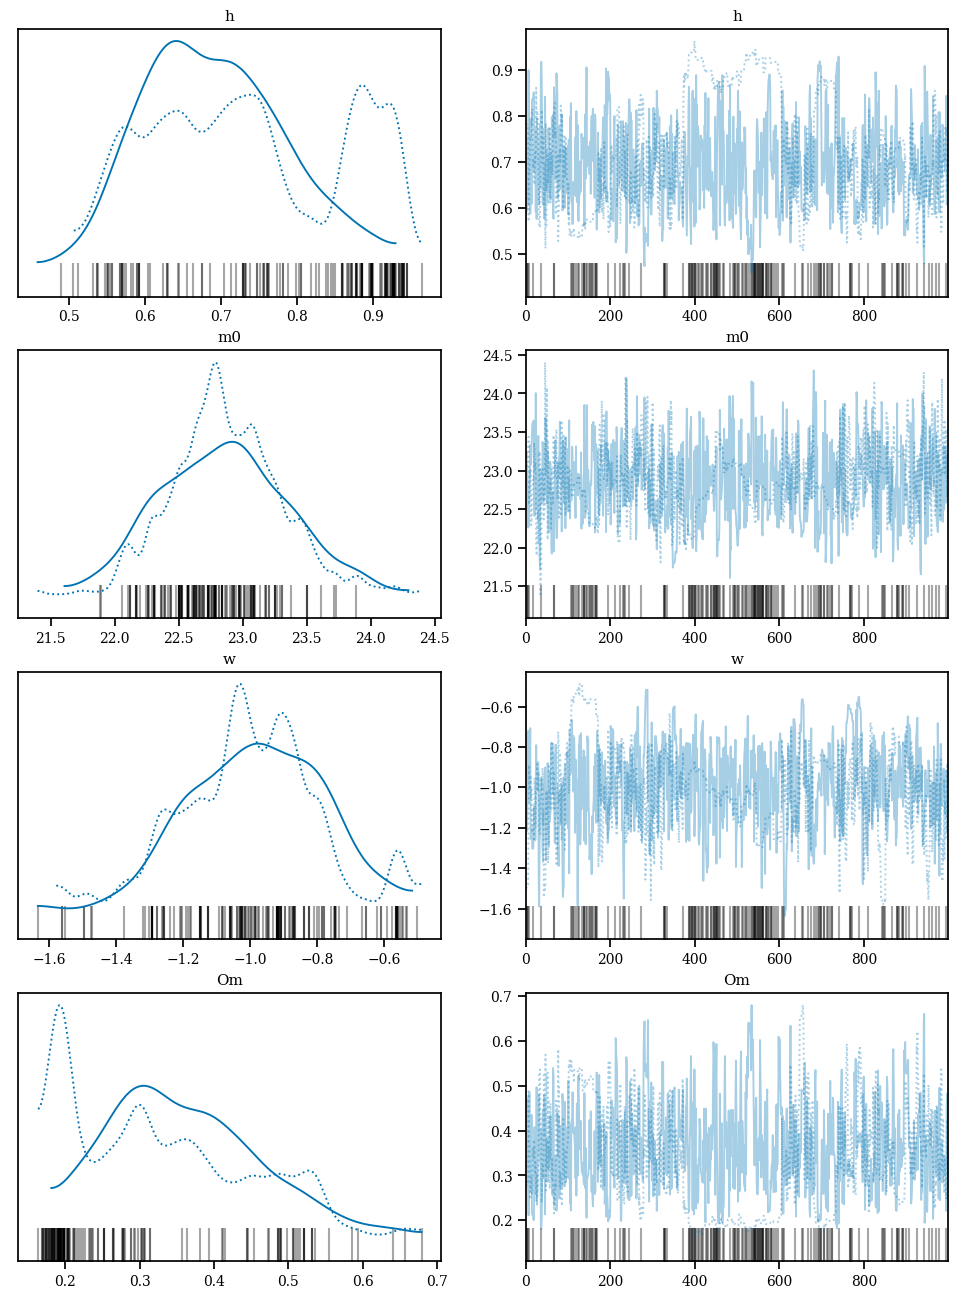

In [6]:
mu_m = np.mean(mpeak_samples, axis=0)
sigmam = np.std(mpeak_samples, axis=0)


with make_model(ms_obs=mu_m, sigma_ms_obs=sigmam, dls=dL_cent, zmin=1, zmax=3) as model:
    trace = pm.sample(init='jitter+adapt_full')
    az.plot_trace(trace, var_names=['h', 'm0', 'w', 'Om'], figsize=(12, 16))
    trace.posterior['m_peak'] = trace.posterior.m0*(1+trace.posterior.zs) # Create another variable in the trace

Text(0.5, 1.0, 'Log Scale - Emperical Errors')

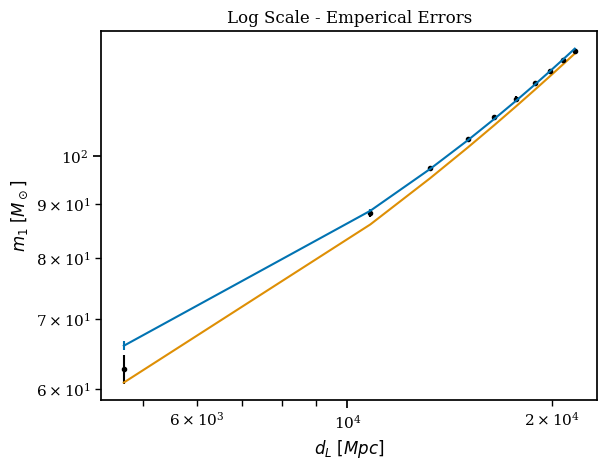

In [7]:
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.errorbar(dL_cent, trace.posterior['m_peak'].mean(dim=['chain', 'draw']), yerr=trace.posterior['m_peak'].std(dim=['chain', 'draw']))
plt.plot(dL_cent, 35*(1+cosmo.z_at_value(Planck18.luminosity_distance, dL_cent*u.Mpc).value),
         label="Planck Cosmology")
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$d_L\ [Mpc]$')
plt.ylabel(r'$m_1\ [M_\odot]$')
plt.title('Log Scale - Emperical Errors')

array([[<AxesSubplot:ylabel='Om'>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='h', ylabel='w'>, <AxesSubplot:xlabel='Om'>]],
      dtype=object)

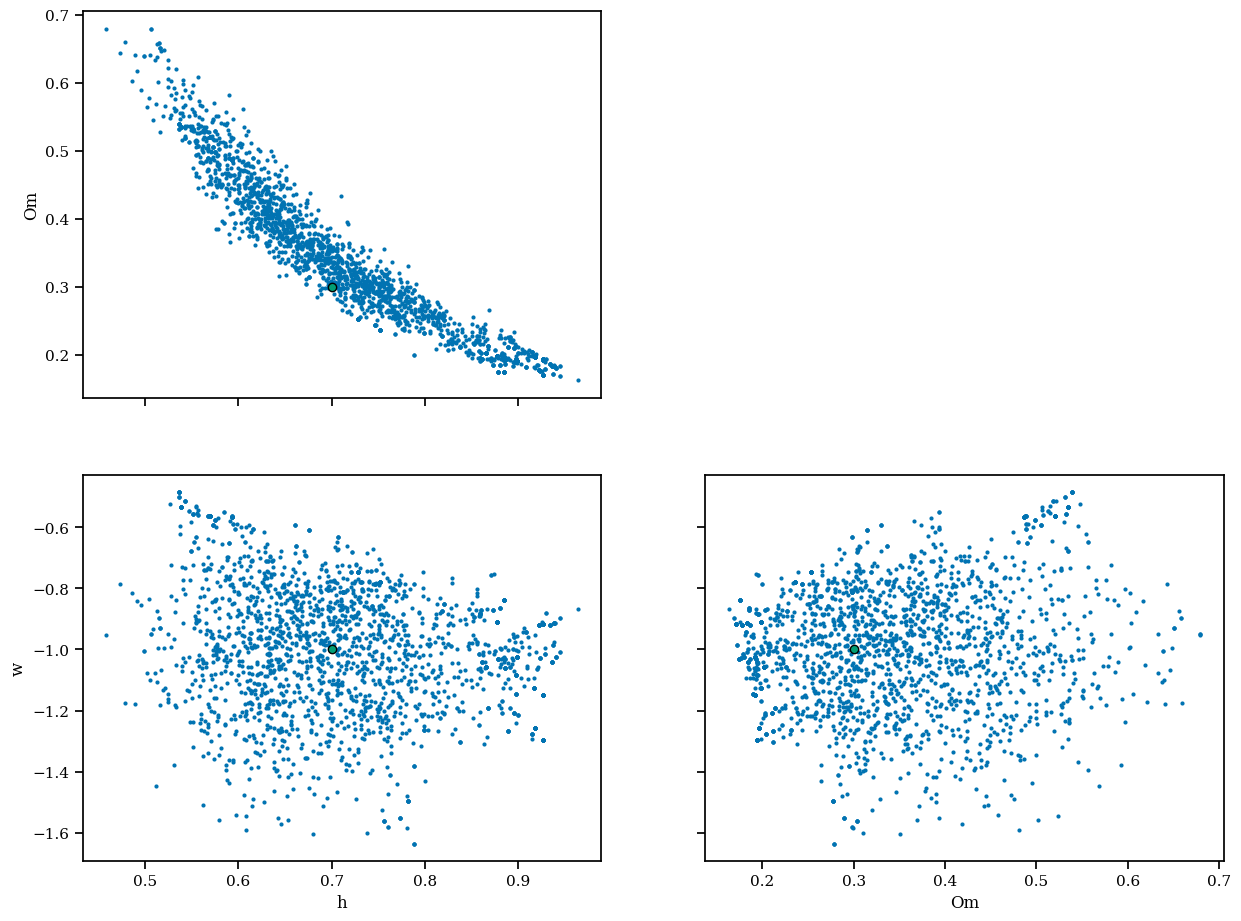

In [8]:
az.plot_pair(trace, var_names=['h', 'Om', 'w'], reference_values={'h': 0.7, 'Om':0.3, 'w':-1})

## Now dropping to z=0

100%|██████████| 8/8 [00:11<00:00,  1.47s/it]


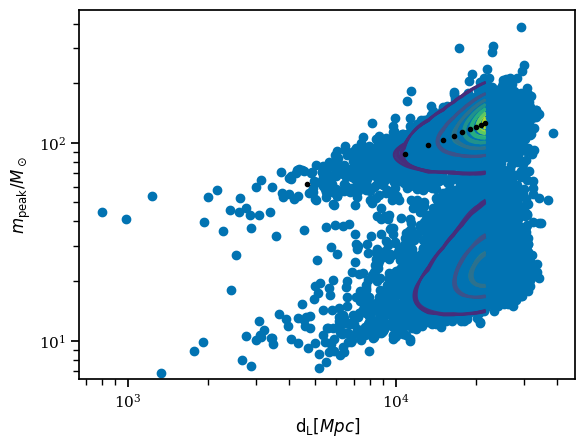

In [9]:
log_mass = np.log(m_det)
log_dl   = np.log(dLs)

n_events = len(m_det)
n_dLs=10
n_mc = 8
m_min = min(m_det)
m_max = max(m_det)
dL_min = min(dLs)
dL_max = max(dLs)
cutoff_d = 22000 #Mpc

m_grid = np.exp(np.linspace(np.log(m_min), np.log(m_max), 1024))
# m_grid = np.linspace(np.log(m_min), np.log(m_max), 1024)
d_low_dl = dLs[dLs < cutoff_d]
dL_cent = np.quantile(d_low_dl, np.linspace(0.01, 0.95, n_dLs))

DLG, MG = np.meshgrid(dL_cent, m_grid, indexing='ij')

mpeak_samples = np.zeros((n_mc, n_dLs))

for run in tqdm(range(n_mc)):

    m_det_mc = np.random.normal(log_mass, sigma_ms)
    d_Ls_mc = np.random.normal(log_dl, sigma_dls)


    
    arr = np.array([d_Ls_mc, m_det_mc])
    kde = gaussian_kde(arr)
    
    pdf = np.exp(kde(np.array([np.log(DLG).ravel(), np.log(MG).ravel()])).reshape(DLG.shape))

    for i in range(n_dLs):
        redshifted_min = 25*(1+cosmo.z_at_value(Planck18.luminosity_distance, dL_cent[i]*u.Mpc))
        mpeak_samples[run,i] = find_argmax_gridsearch(m_grid, pdf[i,:], mmin=redshifted_min)
    
    # kplot = sns.kdeplot(x=(d_Ls_mc), y=(m_det_mc), log_scale=True)
    plt.contour(DLG, MG, pdf) #had to do it a different way no because of the non-linear scaling
    
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.scatter(np.exp(d_Ls_mc), np.exp(m_det_mc))
plt.xlabel(r'$\mathrm{d_L}[Mpc]$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')
# plt.ylim(top=250)
plt.xscale('log')
plt.yscale('log')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
/Users/tanner/miniconda3/lib/python3.9/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 2 chains for 4_000 tune and 4_000 draw iterations (8_000 + 8_000 draws total) took 295 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


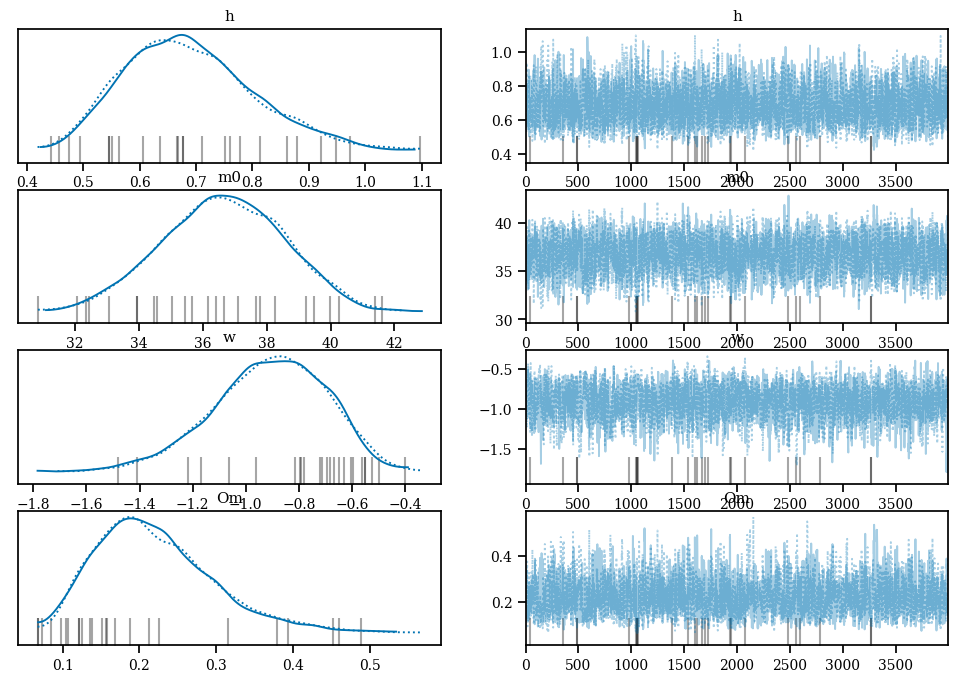

In [10]:
mu_m = np.mean(mpeak_samples, axis=0)
sigmam = np.std(mpeak_samples, axis=0)

with make_model(ms_obs=mu_m, sigma_ms_obs=sigmam, dls=dL_cent, zmin=0, zmax=3) as model:
    trace = pm.sample(target_accept=0.95, tune=4000, draws=4000, init='jitter+adapt_full')
    az.plot_trace(trace, var_names=['h', 'm0', 'w', 'Om'])
    trace.posterior['m_peak'] = trace.posterior.m0*(1+trace.posterior.zs) # Create another variable in the trace

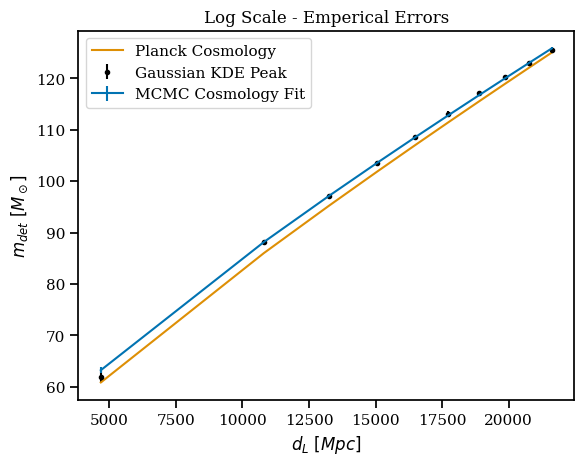

In [14]:
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0),
             fmt='.', c='k', label="Gaussian KDE Peak")
plt.errorbar(dL_cent, trace.posterior['m_peak'].mean(dim=['chain', 'draw']),
              yerr=trace.posterior['m_peak'].std(dim=['chain', 'draw']),
              label="MCMC Cosmology Fit")
plt.plot(dL_cent, 35*(1+cosmo.z_at_value(Planck18.luminosity_distance, dL_cent*u.Mpc).value),
         label="Planck Cosmology")
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel(r'$d_L\ [Mpc]$')
plt.ylabel(r'$m_{det}\ [M_\odot]$')
plt.title('Log Scale - Emperical Errors')
plt.legend()

array([[<AxesSubplot:ylabel='Om'>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='h', ylabel='w'>, <AxesSubplot:xlabel='Om'>]],
      dtype=object)

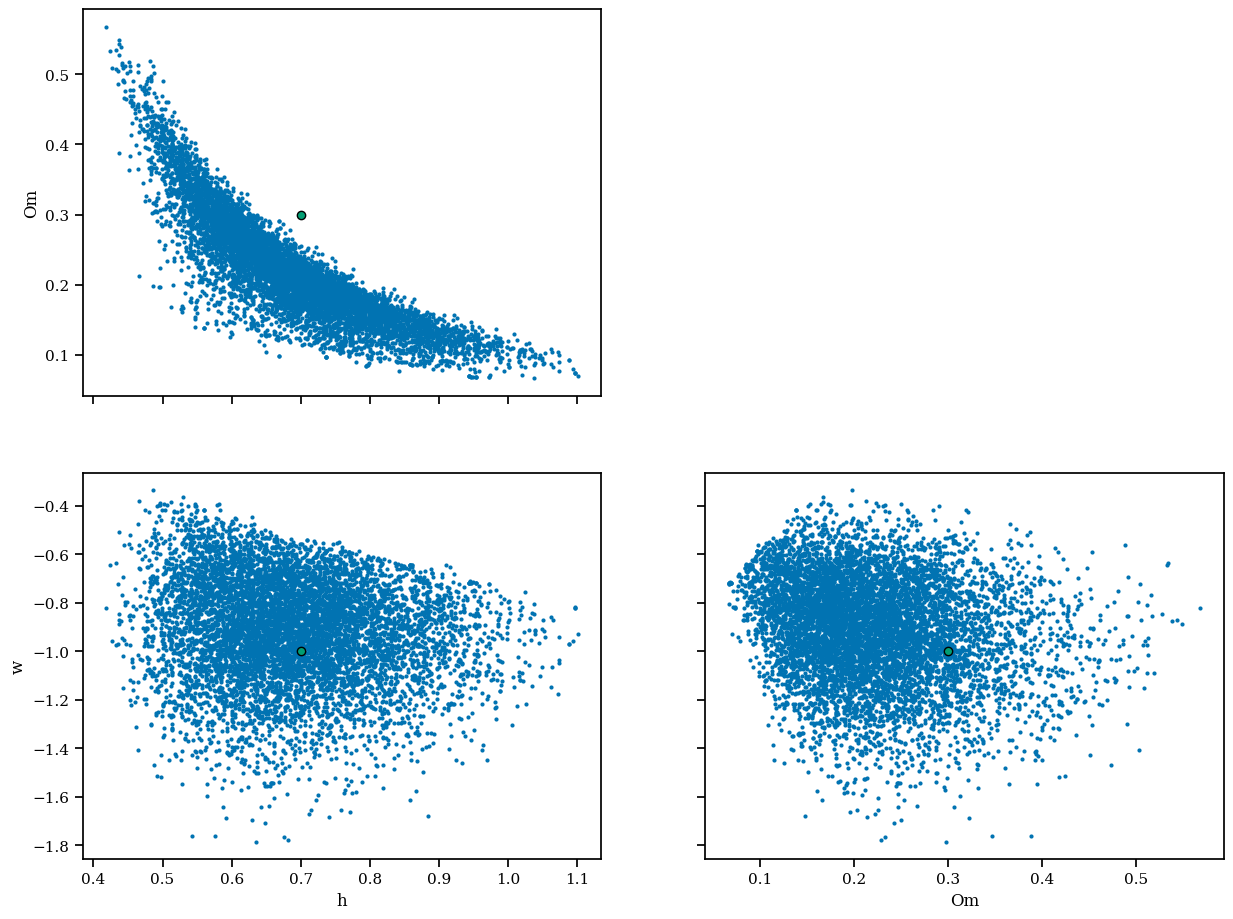

In [12]:
az.plot_pair(trace, var_names=['h', 'Om', 'w'], reference_values={'h': 0.7, 'Om':0.3, 'w':-1})

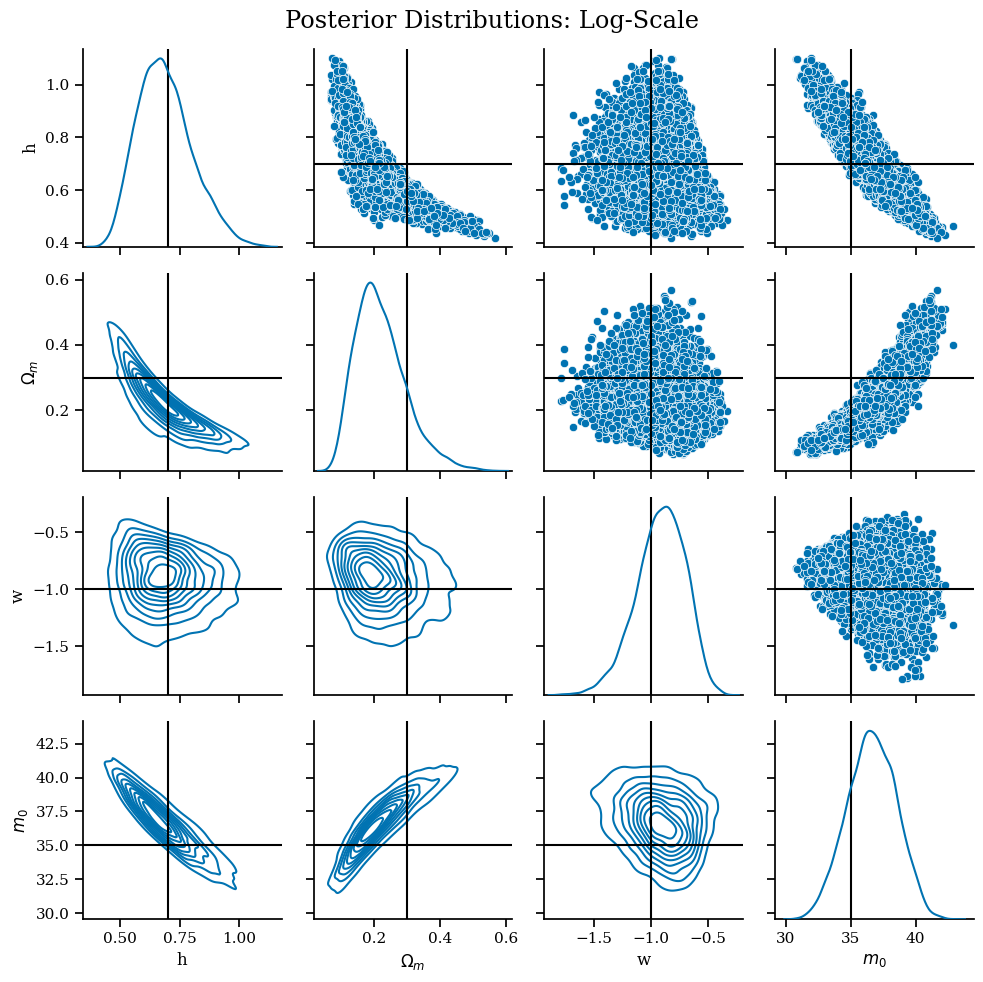

In [13]:
log_df = trace.posterior[['h', 'Om', 'w', 'm0']].to_dataframe()

g = sns.PairGrid(log_df, diag_sharey=False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)

replacements = {'Om': r'$\Omega_m$', 'm0': r'$m_0$'}
true_values = [0.7, 0.3, -1, 35]

for i in range(4):
    for j in range(4):
        xlabel = g.axes[i][j].get_xlabel()
        ylabel = g.axes[i][j].get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])
        if i == j:
            # Diagonal plots
            g.axes[i,j].axvline(true_values[i], color='k')
        else:
            g.axes[i,j].axvline(true_values[j], color='k') # Not sure if this is the right ordering of i (rows) and j (cols)
            g.axes[i,j].axhline(true_values[i], color='k')
g.figure.suptitle("Posterior Distributions: Log-Scale", size='x-large')
g.figure.tight_layout()